In [1]:
import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,StratifiedKFold, GridSearchCV
from sklearn import metrics, set_config#, cross_validation
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer#,make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
%matplotlib inline
set_config(display='diagram')

In [2]:
df2 = pd.read_csv(r'.csv')
X = df2.drop(['Revenue'], axis='columns')
y = df2.Revenue

In [3]:
# df2.info()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42, stratify = y)

In [5]:
display(y_train.value_counts(normalize=True))
y_test.value_counts(normalize=True)

False    0.845209
True     0.154791
Name: Revenue, dtype: float64

False    0.845364
True     0.154636
Name: Revenue, dtype: float64

In [6]:
column_trans = make_column_transformer(
    (OrdinalEncoder(categories=[["Feb", "Mar", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]), ['Month']),
    (OneHotEncoder(handle_unknown = 'ignore', sparse = False), ['Weekend', 'VisitorType' ,'OperatingSystems','Browser','Region','TrafficType']),
    remainder='passthrough')

In [7]:
logreg = LogisticRegression()

In [8]:
pipe = make_pipeline(column_trans, logreg)

In [9]:
pipe.fit(X_train,y_train)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Feb',
                                                                              'Mar',
                                                                              'May',
                                                                              'June',
                                                                              'Jul',
                                                                              'Aug',
                                                                              'Sep',
                                                                              'Oct',
                                                                              'Nov',
                                                                              'Dec']]),
                                                  ['Month']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Weekend', 'VisitorType',
                                                   'OperatingSystems',
                                                   'Browser', 'Region',
                                                   'TrafficType'])])),
                ('logisticregression', LogisticRegression())])

In [10]:
display(pipe.predict(X.iloc[64:66,:]))
df2.iloc[64:66,:]

array([False, False])

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
64,0,0.000000,0,0.0,1,0.000000,0.2,0.200000,0.000000,0.0,Feb,2,2,4,3,Returning_Visitor,False,False
65,3,87.833333,0,0.0,27,798.333333,0.0,0.012644,22.916036,0.8,Feb,2,2,3,1,Returning_Visitor,False,True


In [11]:
y_predict = pipe.predict(X_test)

In [12]:
print(metrics.accuracy_score(y_test, y_predict))

0.8786158421194917


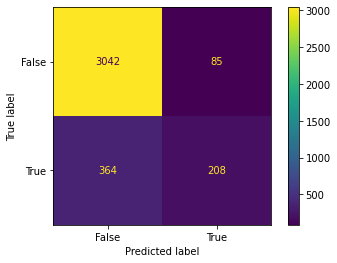

In [13]:
plot_confusion_matrix(pipe, X_test,y_test)

In [14]:
(3043+207)/(3043+207+84+365)

0.8786158421194917

In [15]:
print(metrics.classification_report(y_test, y_predict) )

              precision    recall  f1-score   support

       False       0.89      0.97      0.93      3127
        True       0.71      0.36      0.48       572

    accuracy                           0.88      3699
   macro avg       0.80      0.67      0.71      3699
weighted avg       0.86      0.88      0.86      3699



## Adjusting the threshold

In [16]:
adjust_df = pd.DataFrame(pipe.predict_proba(X_test), columns = ['False','True'])

In [17]:
y_test[:5]

136      False
3454     False
10365    False
11007     True
9291      True
Name: Revenue, dtype: bool

In [18]:
y_predict[:5]

array([False, False, False, False, False])

In [19]:
adjust_df['y_test'] = y_test.values
adjust_df['y_predict'] = y_predict
adjust_df.head()

,False,True,y_test,y_predict
0,0.920986,0.079014,False,False
1,0.898341,0.101659,False,False
2,0.708239,0.291761,False,False
3,0.895363,0.104637,True,False
4,0.780305,0.219695,True,False


In [20]:
True_predict_False = adjust_df[(adjust_df['y_test'] == True) & (adjust_df['y_predict']==False)]['True']#.hist(figsize = (16,4), rwidth = 0.9)
False_predict_True= adjust_df[(adjust_df['y_test'] == False) & (adjust_df['y_predict']==True)]['False']#.hist(figsize = (16,4), rwidth = 0.9)

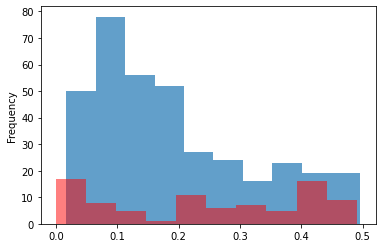

In [21]:
plt.hist(True_predict_False,alpha=0.7, bins=10)
plt.hist(False_predict_True,alpha=0.5, bins=10, color = 'r')
plt.ylabel('Frequency')
plt.show()

In [22]:
# predict True if the predicted probability is greater than 0.2
from sklearn.preprocessing import binarize
y_pred_class = binarize([pipe.predict_proba(X_test)[:, 1]], 0.2)[0]

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [23]:
display(pipe.predict_proba(X_test)[0:10, 1])
y_pred_class[0:10]

array([0.07901371, 0.10165937, 0.29176148, 0.10463658, 0.21969505,
       0.06247044, 0.0784599 , 0.09106137, 0.09880467, 0.1158873 ])

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])

### Before adjustment

[[3042   85]
 [ 364  208]]


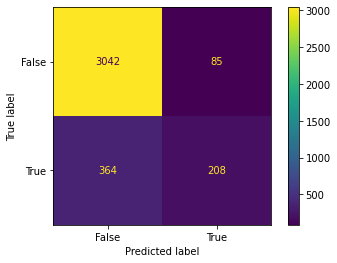

In [24]:
#before adjustment
plot_confusion_matrix(pipe, X_test,y_test)
print(metrics.confusion_matrix(y_test,y_predict))

### Afterwards

In [25]:
print(metrics.accuracy_score(y_test, y_pred_class))

0.8596918085969181


In [26]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2837  290]
 [ 229  343]]


In [27]:
print(metrics.classification_report(y_test, y_pred_class) )

              precision    recall  f1-score   support

       False       0.93      0.91      0.92      3127
        True       0.54      0.60      0.57       572

    accuracy                           0.86      3699
   macro avg       0.73      0.75      0.74      3699
weighted avg       0.87      0.86      0.86      3699



In [28]:
# # prediction vs. actual
# display( binarize([pipe.predict_proba(X_test.sample(15, random_state = 52))[:, 1]], 0.2)[0])
# pd.concat([pd.DataFrame(pipe.predict(X.sample(10, random_state = 46))),
pd.concat([pd.DataFrame(binarize([pipe.predict_proba(X_test.sample(15, random_state = 52))[:, 1]], 0.2)[0]),
           pd.DataFrame(y[y.index.isin(X_test.sample(15, random_state = 52).index)]).reset_index()],axis=1).drop(columns = ['index']).rename(columns = {0:'prediction'})

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,prediction,Revenue
0,0.0,False
1,0.0,False
2,0.0,False
3,1.0,False
4,0.0,False
5,0.0,False
6,0.0,False
7,0.0,False
8,0.0,False
9,0.0,True
